<a href="https://colab.research.google.com/github/lokeshcv/ComputerVisionDeepLearning/blob/main/pytorch_vision_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision.transforms import ToTensor
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import zipfile

Resuable Functions

In [7]:
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_mnist(batch_size=64):
    data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
    data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())
    train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

    return data_train, data_test, train_loader, test_loader

def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = net(features.to(default_device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out,lbls)
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep+1:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(default_device)
            optimizer.zero_grad()
            out = net(features.to(default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))


def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

def plot_convolution(data_train, t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = data_train[i][0]
            ax[0][i].imshow(im[0], cmap='gray')
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0], cmap='gray')
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)#, cmap='gray')
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        #plt.tight_layout()
        plt.show()

def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])


def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return True
    except:
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image: {}".format(fn))
            os.remove(fn)


def common_transform():
    std_normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    trans = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            std_normalize])
    return trans

def load_cats_dogs_dataset():
    if not os.path.exists('data/PetImages'):
        with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
            zip_ref.extractall('data')

    check_image_dir('data/PetImages/Cat/*.jpg')
    check_image_dir('data/PetImages/Dog/*.jpg')

    dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=common_transform())
    trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    testloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    return dataset, trainloader, testloader

In [5]:
train_ds, test_ds, train_loader, test_loader = load_mnist(batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 281647729.54it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24940435.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 147206134.32it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 24084107.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.

They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

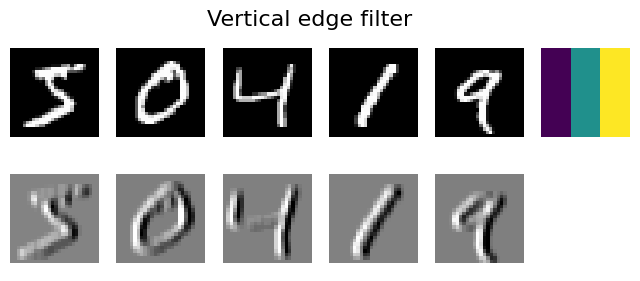

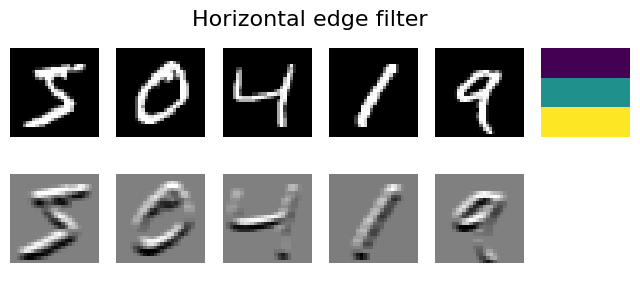

In [8]:
plot_convolution(train_ds,
                 torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),
                 'Vertical edge filter')
plot_convolution(train_ds,
                 torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),
                 'Horizontal edge filter')

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that learn best convolutional filters to solve classification problem.

To do that, we introduce convolutional layers.

### Covolutional layers

Convolutional layers are defined using nn.Conv2d construction

In [10]:
class OneConv(nn.Module):

  def __init__(self):
    super(OneConv, self).__init__()
    self.conv = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(5,5))
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(4608 , 10)

  def forward(self, x):
    x = self.conv(x)
    x = nn.functional.relu(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = nn.functional.log_softmax(x, dim=1)
    return x

net= OneConv()
summary(net, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 24, 24]            208
├─Flatten: 1-2                           [1, 4608]                 --
├─Linear: 1-3                            [1, 10]                   46,090
Total params: 46,298
Trainable params: 46,298
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.19
Estimated Total Size (MB): 0.23

Epoch  1, Train acc=0.947, Val acc=0.969, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.978, Val acc=0.971, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.984, Val acc=0.977, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.986, Val acc=0.976, Train loss=0.000, Val loss=0.001
Epoch  5, Train acc=0.988, Val acc=0.977, Train loss=0.000, Val loss=0.001


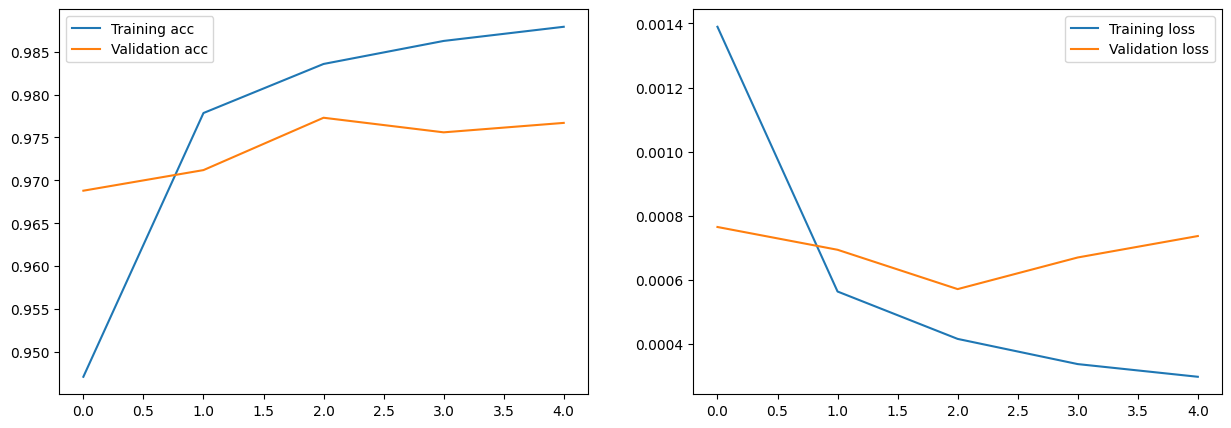

In [11]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on




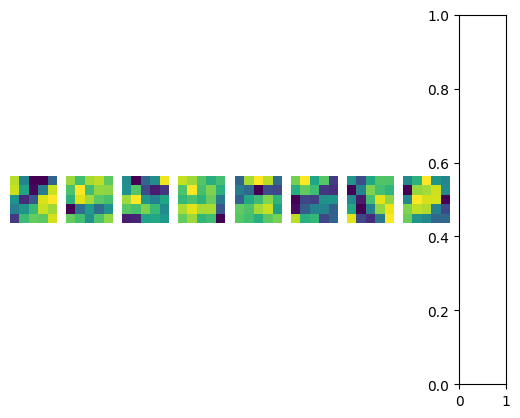

In [14]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

### Multi-Layered CNNs